In [354]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib import ticker
from matplotlib import rcParams
from matplotlib import patches
import xarray as xr
import scipy.io
import astropy.constants as const
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
import pandas as pd
import ChiantiPy.core as ch
import copy
from scipy import interpolate
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from fitting_template import FeXII_fit
from fitting_template import myGaussian1D
from astropy.modeling import models, fitting, Fittable1DModel, Parameter

In [214]:
m_p = const.m_p.cgs.value
k_b = const.k_B.cgs.value
c = const.c.cgs.value
rs = const.R_sun.cgs.value

In [4]:
lon0 = pd.read_csv('../awsom_test/long0.txt',skiprows=10,names=['rs','lon','lat','n','ti','te','b_x','b_y','b_z','I01','I02','NV'],sep='\s+',
                encoding='utf-8',skipfooter=0,dtype={'':np.float64})

In [5]:
lon180 = pd.read_csv('../awsom_test/long180.txt',skiprows=10,names=['rs','lon','lat','n','ti','te','b_x','b_y','b_z','I01','I02','NV'],sep='\s+',
                encoding='utf-8',skipfooter=1,dtype={'':np.float64})

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


In [6]:
data = pd.concat([lon0,lon180])

In [7]:
df1 = data.assign(x = data['rs']*np.cos(np.deg2rad(data['lat']))*np.cos(np.deg2rad(data['lon'])))

In [8]:
df2 = df1.assign(y = data['rs']*np.sin(np.deg2rad(data['lat'])))

In [112]:
df3 = df2.assign(w = (df2['I01']+df2['I02'])*1.e-13)

In [94]:
df4 = df3.loc[(df3['y'] > -1.25) & (df3['y'] <-1.15) & (df3['rs']<3)]

In [95]:
df4

,rs,lon,lat,n,ti,te,b_x,b_y,b_z,I01,I02,NV,x,y,w
1,1.1693,0.0,-90.0,20256000.0,960370.0,1065100.0,-25536.0,1439.20,356040.0,206210000.0,1.681000e+11,2.322900e+14,7.159898e-17,-1.169300,1.683062e+24
2,1.1885,0.0,-90.0,18882000.0,959940.0,1069400.0,-24662.0,1386.50,342600.0,199380000.0,1.603600e+11,2.329700e+14,7.277464e-17,-1.188500,1.605594e+24
3,1.2077,0.0,-90.0,16481000.0,959180.0,1076900.0,-23135.0,1294.30,319090.0,187440000.0,1.468200e+11,2.341700e+14,7.395030e-17,-1.207700,1.470074e+24
4,1.2270,0.0,-90.0,14118000.0,958440.0,1084300.0,-21631.0,1203.60,295960.0,175690000.0,1.335000e+11,2.353400e+14,7.513208e-17,-1.227000,1.336757e+24
5,1.2462,0.0,-90.0,12269000.0,951880.0,1089200.0,-20273.0,1121.40,275880.0,170040000.0,1.222100e+11,2.362200e+14,7.630774e-17,-1.246200,1.223800e+24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14966,2.9210,180.0,-23.4,37829.0,2449000.0,759240.0,12123.0,-500.56,2648.7,2430300.0,4.316400e+09,1.049800e+13,-2.680761e+00,-1.160069,4.318830e+22
14967,2.9402,180.0,-23.4,36861.0,2473300.0,758050.0,11933.0,-484.28,2623.9,2395100.0,4.234300e+09,1.032300e+13,-2.698382e+00,-1.167694,4.236695e+22
14968,2.9595,180.0,-23.4,35900.0,2497400.0,756870.0,11745.0,-468.10,2599.2,2360100.0,4.152800e+09,1.015000e+13,-2.716095e+00,-1.175359,4.155160e+22
14969,2.9787,180.0,-23.4,35008.0,2517000.0,756100.0,11597.0,-462.45,2584.4,2334800.0,4.091600e+09,1.002500e+13,-2.733716e+00,-1.182984,4.093935e+22


In [19]:
f_interp = interpolate.interp2d(df3['x'], df3['y'], df3['I01'])

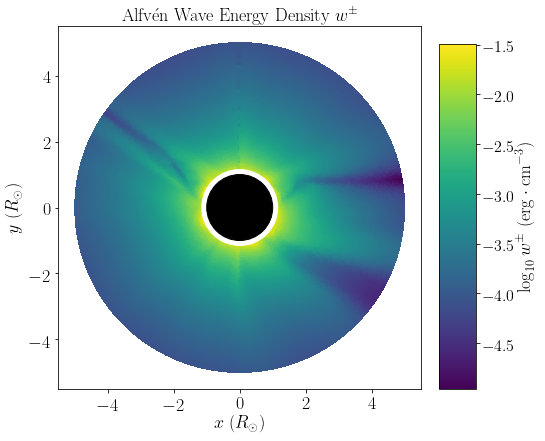

In [413]:
circle1 = plt.Circle((0, 0), 1, color='black')
circle2 = plt.Circle((0, 0), 1.15, color='w')
fig, ax = plt.subplots(figsize=(8,6))
#im = ax.tripcolor(df2['x'],df2['y'],df3['w'],vmin = 1.2*np.min(df3['w']),vmax = 0.8*np.max(df3['w']))
im = ax.tripcolor(df2['x'],df2['y'],np.log10(df3['w']))
ax.set_xlabel(r'',fontsize=24)
ax.set_ylabel(r'',fontsize=24)
ax.tick_params(labelsize=18)
ax.set_aspect('equal')
ax.add_artist(circle2)
ax.add_artist(circle1)
clb_ax = inset_axes(ax,width="10%",height= "95%",loc='lower left',
                bbox_to_anchor=(1.05, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel('$\log_{10} w^\pm \ (\mathrm{erg\cdot cm^{-3}})$',fontsize=18)
ax.set_title(r'Alfv\'en Wave Energy Density $w^\pm$',fontsize=18)
ax.set_xlabel('$x\ (R_\odot)$',fontsize=18)
ax.set_ylabel('$y\ (R_\odot)$',fontsize=18)
plt.subplots_adjust(bottom = 0.1,left=0.05,top=0.94,right=0.9)
plt.savefig(fname = r'/Users/yjzhu/Desktop/Courses/2020WIN/SPACE477/project3/figs/w.pdf', dpi = 300, format = 'pdf')

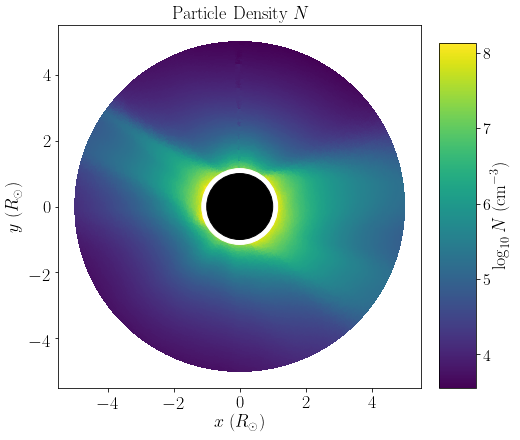

In [81]:
circle1 = plt.Circle((0, 0), 1, color='black')
circle2 = plt.Circle((0, 0), 1.15, color='w')
fig, ax = plt.subplots(figsize=(8,6))
im = ax.tripcolor(df2['x'],df2['y'],np.log10(df3['n']),vmin = np.log10(np.min(df3['n'])),vmax = np.log10(np.max(df3['n'])))
ax.set_xlabel(r'',fontsize=24)
ax.set_ylabel(r'',fontsize=24)
ax.tick_params(labelsize=18)
ax.set_aspect('equal')
ax.add_artist(circle2)
ax.add_artist(circle1)
clb_ax = inset_axes(ax,width="10%",height= "95%",loc='lower left',
                bbox_to_anchor=(1.05, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel('$\log_{10} N \ (\mathrm{cm^{-3}})$',fontsize=18)
ax.set_title(r'Particle Density $N$',fontsize=18)
ax.set_xlabel('$x\ (R_\odot)$',fontsize=18)
ax.set_ylabel('$y\ (R_\odot)$',fontsize=18)
plt.subplots_adjust(bottom = 0.1,left=0.05,top=0.94,right=0.9)
plt.savefig(fname = r'/Users/yjzhu/Desktop/Courses/2020WIN/SPACE477/project3/figs/N.pdf', dpi = 300, format = 'pdf')

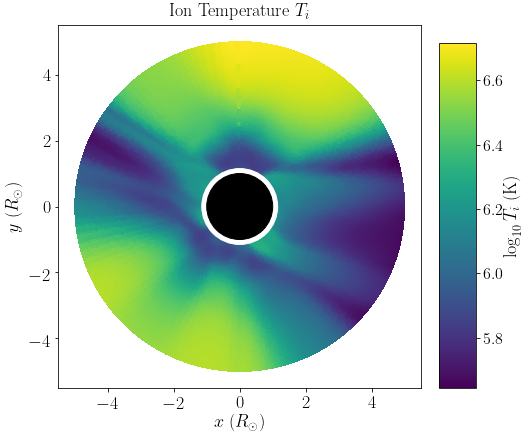

In [385]:
circle1 = plt.Circle((0, 0), 1, color='black')
circle2 = plt.Circle((0, 0), 1.15, color='w')
fig, ax = plt.subplots(figsize=(8,6))
im = ax.tripcolor(df2['x'],df2['y'],np.log10(df3['ti']),vmin = np.log10(np.min(df3['ti'])),vmax = np.log10(np.max(df3['ti'])))
ax.set_xlabel(r'',fontsize=24)
ax.set_ylabel(r'',fontsize=24)
ax.tick_params(labelsize=18)
ax.set_aspect('equal')
ax.add_artist(circle2)
ax.add_artist(circle1)
clb_ax = inset_axes(ax,width="10%",height= "95%",loc='lower left',
                bbox_to_anchor=(1.05, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel('$\log_{10} T_i \ (\mathrm{K})$',fontsize=18)
ax.set_title(r'Ion Temperature $T_i$',fontsize=18)
ax.set_xlabel('$x\ (R_\odot)$',fontsize=18)
ax.set_ylabel('$y\ (R_\odot)$',fontsize=18)
plt.subplots_adjust(bottom = 0.1,left=0.05,top=0.94,right=0.9)
plt.savefig(fname = r'/Users/yjzhu/Desktop/Courses/2020WIN/SPACE477/project3/figs/ti.pdf', dpi = 300, format = 'pdf')

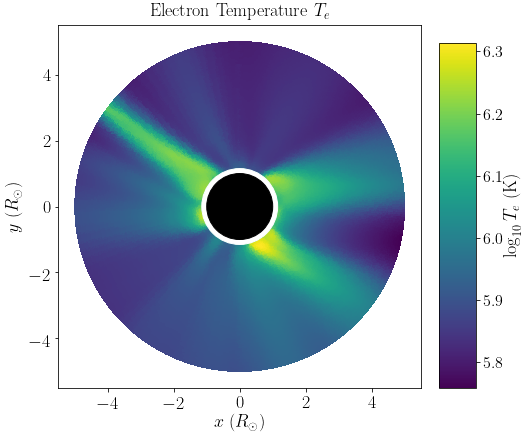

In [384]:
circle1 = plt.Circle((0, 0), 1, color='black')
circle2 = plt.Circle((0, 0), 1.15, color='w')
fig, ax = plt.subplots(figsize=(8,6))
im = ax.tripcolor(df2['x'],df2['y'],np.log10(df3['te']),vmin = np.log10(np.min(df3['te'])),vmax = np.log10(np.max(df3['te'])))
ax.set_xlabel(r'',fontsize=24)
ax.set_ylabel(r'',fontsize=24)
ax.tick_params(labelsize=18)
ax.set_aspect('equal')
ax.add_artist(circle2)
ax.add_artist(circle1)
clb_ax = inset_axes(ax,width="10%",height= "95%",loc='lower left',
                bbox_to_anchor=(1.05, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel('$\log_{10} T_e \ (\mathrm{K})$',fontsize=18)
ax.set_title(r'Electron Temperature $T_e$',fontsize=18)
ax.set_xlabel('$x\ (R_\odot)$',fontsize=18)
ax.set_ylabel('$y\ (R_\odot)$',fontsize=18)
plt.subplots_adjust(bottom = 0.1,left=0.05,top=0.94,right=0.9)
plt.savefig(fname = r'/Users/yjzhu/Desktop/Courses/2020WIN/SPACE477/project3/figs/te.pdf', dpi = 300, format = 'pdf')

In [295]:
lambda0 = 193.509
wvl = np.linspace(lambda0 - 0.25, lambda0 +0.25,51)

In [380]:
%store -r data_193_erg
%store -r wvl_193
%store -r r_coord
%store -r fwhm_193_cor
%store -r fwhm_193_err
%store -r fwhm_193_cor_mcmc
%store -r fwhm_193_err_down_mcmc
%store -r fwhm_193_err_up_mcmc

In [399]:
df4 = df3.loc[(df3['y'] > -1.22) & (df3['y'] <-1.18) & (df3['rs']<2.6)]

n_point = 21
xx = np.linspace(-2.5,2.5,n_point)
yy = np.ones_like(xx)*-1.2
dx = 5/(n_point-1)
n_interp = np.ones_like(xx)
w_interp = np.ones_like(xx)
ti_interp = np.ones_like(xx)
te_interp = np.ones_like(xx)
bx_interp = np.ones_like(xx)
by_interp = np.ones_like(xx)
bz_interp = np.ones_like(xx)
#gt = np.ones_like(xx)
for ii in range(n_point):
    df_mean = df4.loc[(df4['x']<xx[ii]+dx/2) & (df4['x']>xx[ii]-dx/2) ]
    n_interp[ii] = np.mean(df_mean['n'])
    w_interp[ii] = np.mean(df_mean['w'])
    ti_interp[ii] = np.mean(df_mean['ti'])
    te_interp[ii] = np.mean(df_mean['te'])
    bx_interp[ii] = np.mean(df_mean['b_x'])
    by_interp[ii] = np.mean(df_mean['b_y'])
    bz_interp[ii] = np.mean(df_mean['b_z'])

    ti_interp = np.nan_to_num(ti_interp,nan=1.e4)
    
cos_interp = np.sqrt(1 - np.square(bx_interp)/(np.square(bx_interp)+np.square(by_interp)+np.square(bz_interp)))
cos_interp = np.nan_to_num(cos_interp,nan=1)
vnt_interp = 0.5*np.sqrt(w_interp/m_p/n_interp)*cos_interp
#vnt_interp = 0.5*np.sqrt(w_interp/m_p/n_interp)
vnt_interp = np.nan_to_num(vnt_interp,nan=0)

fe12 = ch.ion('fe_12',temperature=te_interp,eDensity=n_interp)
fe12.intensity()
idx = np.abs(np.asarray(fe12.Intensity['wvl']) - 193.509).argmin()
gt = fe12.Intensity['intensity'][:,idx]
gt = np.nan_to_num(gt,nan=0)

n_interp = np.nan_to_num(n_interp,nan=0)

dlambda = lambda0*np.sqrt(2*k_b*ti_interp/56/m_p + np.square(vnt_interp))/c

phi_lambda = np.zeros((n_point,wvl.shape[0]))
for ii in range(n_point):
    phi_lambda[ii,:] = 1/np.sqrt(np.pi)/dlambda[ii]*np.exp(-np.square((wvl-lambda0)/dlambda[ii]))
    
ci = phi_lambda*gt[:,np.newaxis]
ci = np.nan_to_num(ci,nan=0)
int_out = np.sum(ci*np.square(n_interp)[:,None]*rs*dx,axis=0)/4/np.pi

/anaconda3/lib/python3.7/site-packages/ChiantiPy-0.9.1-py3.7.egg/ChiantiPy/base/_IonTrails.py:29: RuntimeWarning: invalid value encountered in less_equal
  if np.any(self.Temperature <= 0.):
/anaconda3/lib/python3.7/site-packages/ChiantiPy-0.9.1-py3.7.egg/ChiantiPy/base/_IoneqOne.py:35: RuntimeWarning: invalid value encountered in greater_equal
  goodt1 = self.Temperature >= ioneqTemperature[gioneq].min()
/anaconda3/lib/python3.7/site-packages/ChiantiPy-0.9.1-py3.7.egg/ChiantiPy/base/_IoneqOne.py:36: RuntimeWarning: invalid value encountered in less_equal
  goodt2 = self.Temperature <= ioneqTemperature[gioneq].max()
/anaconda3/lib/python3.7/site-packages/ChiantiPy-0.9.1-py3.7.egg/ChiantiPy/core/Ion.py:1014: RuntimeWarning: invalid value encountered in greater
  ups=np.where(ups > 0.,ups,0.)


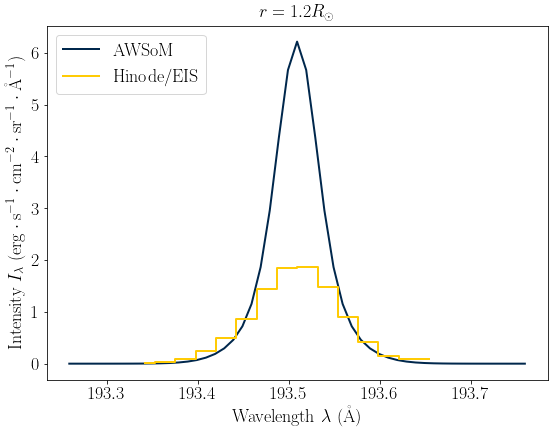

In [400]:
fig, ax = plt.subplots(figsize=(8,6))
ln1, = ax.plot(wvl,int_out,linewidth=2,color="#00274C",label = 'AWSoM')
ln2, = ax.step(wvl_193+0.07,data_193_erg[-12,:] - 0.3,where = "mid",linewidth=2,color="#FFCB05",label = 'Hinode/EIS')
ax.set_xlabel(r'Wavelength $\lambda\ (\mathrm{\AA})$',fontsize=18)
ax.set_ylabel(r'Intensity $I_\lambda\ (\mathrm{erg\cdot s^{-1} \cdot cm^{-2} \cdot sr^{-1} \cdot \AA^{-1}})$',fontsize=18)
ax.tick_params(labelsize=18)
leg = [ln1,ln2]
ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper left',fontsize = 18)
ax.set_title(r'$r = 1.2R_\odot$',fontsize=18)
plt.subplots_adjust(bottom = 0.12,left=0.1,top=0.94,right=0.97)
plt.savefig(fname = r'/Users/yjzhu/Desktop/Courses/2020WIN/SPACE477/project3/figs/R12.pdf', dpi = 300, format = 'pdf')

In [345]:
r_coord[30]


1.5083664387608966

In [401]:
df4 = df3.loc[(df3['y'] > -1.32) & (df3['y'] <-1.28) & (df3['rs']<2.6)]

n_point = 21
xx = np.linspace(-2.5,2.5,n_point)
yy = np.ones_like(xx)*-1.3
dx = 5/(n_point-1)
n_interp = np.ones_like(xx)
w_interp = np.ones_like(xx)
ti_interp = np.ones_like(xx)
te_interp = np.ones_like(xx)
bx_interp = np.ones_like(xx)
by_interp = np.ones_like(xx)
bz_interp = np.ones_like(xx)
#gt = np.ones_like(xx)
for ii in range(n_point):
    df_mean = df4.loc[(df4['x']<xx[ii]+dx/2) & (df4['x']>xx[ii]-dx/2) ]
    n_interp[ii] = np.mean(df_mean['n'])
    w_interp[ii] = np.mean(df_mean['w'])
    ti_interp[ii] = np.mean(df_mean['ti'])
    te_interp[ii] = np.mean(df_mean['te'])
    bx_interp[ii] = np.mean(df_mean['b_x'])
    by_interp[ii] = np.mean(df_mean['b_y'])
    bz_interp[ii] = np.mean(df_mean['b_z'])

    ti_interp = np.nan_to_num(ti_interp,nan=1.e4)
    
cos_interp = np.sqrt(1 - np.square(bx_interp)/(np.square(bx_interp)+np.square(by_interp)+np.square(bz_interp)))
cos_interp = np.nan_to_num(cos_interp,nan=1)
vnt_interp = 0.5*np.sqrt(w_interp/m_p/n_interp)*cos_interp
#vnt_interp = 0.5*np.sqrt(w_interp/m_p/n_interp)
vnt_interp = np.nan_to_num(vnt_interp,nan=0)

fe12 = ch.ion('fe_12',temperature=te_interp,eDensity=n_interp)
fe12.intensity()
idx = np.abs(np.asarray(fe12.Intensity['wvl']) - 193.509).argmin()
gt = fe12.Intensity['intensity'][:,idx]
gt = np.nan_to_num(gt,nan=0)

n_interp = np.nan_to_num(n_interp,nan=0)

dlambda = lambda0*np.sqrt(2*k_b*ti_interp/56/m_p + np.square(vnt_interp))/c

phi_lambda = np.zeros((n_point,wvl.shape[0]))
for ii in range(n_point):
    phi_lambda[ii,:] = 1/np.sqrt(np.pi)/dlambda[ii]*np.exp(-np.square((wvl-lambda0)/dlambda[ii]))
    
ci = phi_lambda*gt[:,np.newaxis]
ci = np.nan_to_num(ci,nan=0)
int_out = np.sum(ci*np.square(n_interp)[:,None]*rs*dx,axis=0)/4/np.pi

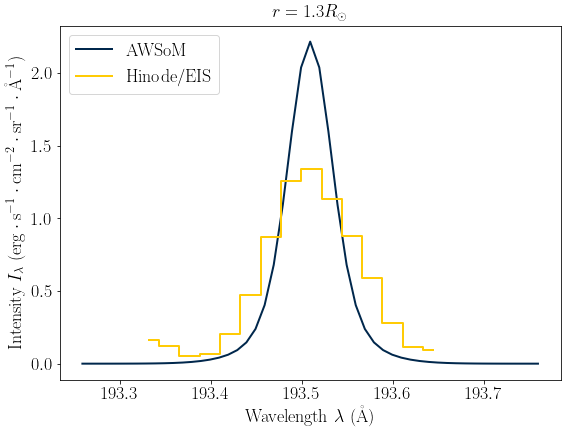

In [402]:
fig, ax = plt.subplots(figsize=(8,6))
ln1, = ax.plot(wvl,int_out,linewidth=2,color="#00274C",label = 'AWSoM')
ln2, = ax.step(wvl_193+0.06,data_193_erg[-17,:]-0.3,where = "mid",linewidth=2,color="#FFCB05",label = 'Hinode/EIS')
ax.set_xlabel(r'Wavelength $\lambda\ (\mathrm{\AA})$',fontsize=18)
ax.set_ylabel(r'Intensity $I_\lambda\ (\mathrm{erg\cdot s^{-1} \cdot cm^{-2} \cdot sr^{-1} \cdot \AA^{-1}})$',fontsize=18)
ax.tick_params(labelsize=18)
leg = [ln1,ln2]
ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper left',fontsize = 18)
ax.set_title(r'$r = 1.3R_\odot$',fontsize=18)
plt.subplots_adjust(bottom = 0.12,left=0.1,top=0.94,right=0.97)
plt.savefig(fname = r'/Users/yjzhu/Desktop/Courses/2020WIN/SPACE477/project3/figs/R13.pdf', dpi = 300, format = 'pdf')

In [405]:
df4 = df3.loc[(df3['y'] > -1.42) & (df3['y'] <-1.38) & (df3['rs']<2.6)]

n_point = 21
xx = np.linspace(-2.5,2.5,n_point)
yy = np.ones_like(xx)*-1.4
dx = 5/(n_point-1)
n_interp = np.ones_like(xx)
w_interp = np.ones_like(xx)
ti_interp = np.ones_like(xx)
te_interp = np.ones_like(xx)
bx_interp = np.ones_like(xx)
by_interp = np.ones_like(xx)
bz_interp = np.ones_like(xx)
#gt = np.ones_like(xx)
for ii in range(n_point):
    df_mean = df4.loc[(df4['x']<xx[ii]+dx/2) & (df4['x']>xx[ii]-dx/2) ]
    n_interp[ii] = np.mean(df_mean['n'])
    w_interp[ii] = np.mean(df_mean['w'])
    ti_interp[ii] = np.mean(df_mean['ti'])
    te_interp[ii] = np.mean(df_mean['te'])
    bx_interp[ii] = np.mean(df_mean['b_x'])
    by_interp[ii] = np.mean(df_mean['b_y'])
    bz_interp[ii] = np.mean(df_mean['b_z'])

    ti_interp = np.nan_to_num(ti_interp,nan=1.e4)
    te_interp = np.nan_to_num(te_interp,nan=1.e4)
    
cos_interp = np.sqrt(1 - np.square(bx_interp)/(np.square(bx_interp)+np.square(by_interp)+np.square(bz_interp)))
cos_interp = np.nan_to_num(cos_interp,nan=1)
vnt_interp = 0.5*np.sqrt(w_interp/m_p/n_interp)*cos_interp
#vnt_interp = 0.5*np.sqrt(w_interp/m_p/n_interp)
vnt_interp = np.nan_to_num(vnt_interp,nan=0)

fe12 = ch.ion('fe_12',temperature=te_interp,eDensity=n_interp)
fe12.intensity()
idx = np.abs(np.asarray(fe12.Intensity['wvl']) - 193.509).argmin()
gt = fe12.Intensity['intensity'][:,idx]
gt = np.nan_to_num(gt,nan=0)

n_interp = np.nan_to_num(n_interp,nan=0)

dlambda = lambda0*np.sqrt(2*k_b*ti_interp/56/m_p + np.square(vnt_interp))/c

phi_lambda = np.zeros((n_point,wvl.shape[0]))
for ii in range(n_point):
    phi_lambda[ii,:] = 1/np.sqrt(np.pi)/dlambda[ii]*np.exp(-np.square((wvl-lambda0)/dlambda[ii]))
    
ci = phi_lambda*gt[:,np.newaxis]
ci = np.nan_to_num(ci,nan=0)
int_out = np.sum(ci*np.square(n_interp)[:,None]*rs*dx,axis=0)/4/np.pi

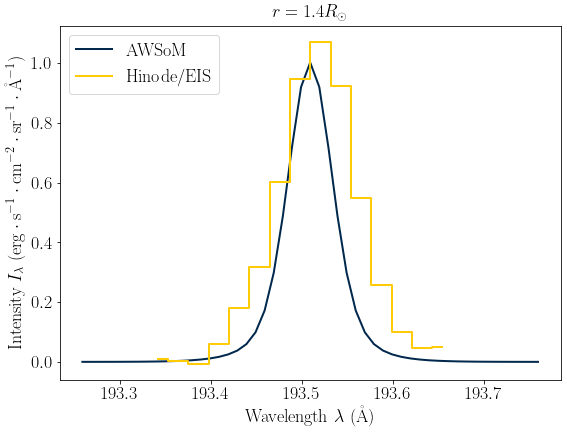

In [406]:
fig, ax = plt.subplots(figsize=(8,6))
ln1, = ax.plot(wvl,int_out,linewidth=2,color="#00274C",label = 'AWSoM')
ln2, = ax.step(wvl_193+0.07,data_193_erg[-24,:]-0.26,where = "mid",linewidth=2,color="#FFCB05",label = 'Hinode/EIS')
ax.set_xlabel(r'Wavelength $\lambda\ (\mathrm{\AA})$',fontsize=18)
ax.set_ylabel(r'Intensity $I_\lambda\ (\mathrm{erg\cdot s^{-1} \cdot cm^{-2} \cdot sr^{-1} \cdot \AA^{-1}})$',fontsize=18)
ax.tick_params(labelsize=18)
leg = [ln1,ln2]
ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper left',fontsize = 18)
ax.set_title(r'$r = 1.4R_\odot$',fontsize=18)
plt.subplots_adjust(bottom = 0.12,left=0.1,top=0.94,right=0.97)
plt.savefig(fname = r'/Users/yjzhu/Desktop/Courses/2020WIN/SPACE477/project3/figs/R14.pdf', dpi = 300, format = 'pdf')

In [407]:
df4 = df3.loc[(df3['y'] > -1.52) & (df3['y'] <-1.48) & (df3['rs']<2.6)]

n_point = 21
xx = np.linspace(-2.5,2.5,n_point)
yy = np.ones_like(xx)*-1.5
dx = 5/(n_point-1)
n_interp = np.ones_like(xx)
w_interp = np.ones_like(xx)
ti_interp = np.ones_like(xx)
te_interp = np.ones_like(xx)
bx_interp = np.ones_like(xx)
by_interp = np.ones_like(xx)
bz_interp = np.ones_like(xx)
#gt = np.ones_like(xx)
for ii in range(n_point):
    df_mean = df4.loc[(df4['x']<xx[ii]+dx/2) & (df4['x']>xx[ii]-dx/2) ]
    n_interp[ii] = np.mean(df_mean['n'])
    w_interp[ii] = np.mean(df_mean['w'])
    ti_interp[ii] = np.mean(df_mean['ti'])
    te_interp[ii] = np.mean(df_mean['te'])
    bx_interp[ii] = np.mean(df_mean['b_x'])
    by_interp[ii] = np.mean(df_mean['b_y'])
    bz_interp[ii] = np.mean(df_mean['b_z'])

    ti_interp = np.nan_to_num(ti_interp,nan=1.e4)
    te_interp = np.nan_to_num(te_interp,nan=1.e4)
    
cos_interp = np.sqrt(1 - np.square(bx_interp)/(np.square(bx_interp)+np.square(by_interp)+np.square(bz_interp)))
cos_interp = np.nan_to_num(cos_interp,nan=1)
vnt_interp = 0.5*np.sqrt(w_interp/m_p/n_interp)*cos_interp
#vnt_interp = 0.5*np.sqrt(w_interp/m_p/n_interp)
vnt_interp = np.nan_to_num(vnt_interp,nan=0)

fe12 = ch.ion('fe_12',temperature=te_interp,eDensity=n_interp)
fe12.intensity()
idx = np.abs(np.asarray(fe12.Intensity['wvl']) - 193.509).argmin()
gt = fe12.Intensity['intensity'][:,idx]
gt = np.nan_to_num(gt,nan=0)

n_interp = np.nan_to_num(n_interp,nan=0)

dlambda = lambda0*np.sqrt(2*k_b*ti_interp/56/m_p + np.square(vnt_interp))/c

phi_lambda = np.zeros((n_point,wvl.shape[0]))
for ii in range(n_point):
    phi_lambda[ii,:] = 1/np.sqrt(np.pi)/dlambda[ii]*np.exp(-np.square((wvl-lambda0)/dlambda[ii]))
    
ci = phi_lambda*gt[:,np.newaxis]
ci = np.nan_to_num(ci,nan=0)
int_out = np.sum(ci*np.square(n_interp)[:,None]*rs*dx,axis=0)/4/np.pi

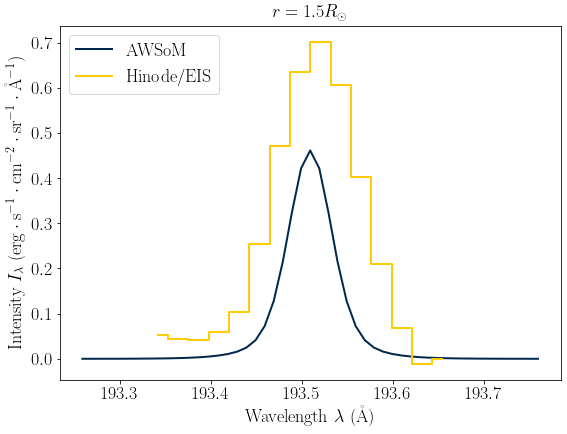

In [408]:
fig, ax = plt.subplots(figsize=(8,6))
ln1, = ax.plot(wvl,int_out,linewidth=2,color="#00274C",label = 'AWSoM')
ln2, = ax.step(wvl_193+0.07,data_193_erg[-30,:]-0.25,where = "mid",linewidth=2,color="#FFCB05",label = 'Hinode/EIS')
ax.set_xlabel(r'Wavelength $\lambda\ (\mathrm{\AA})$',fontsize=18)
ax.set_ylabel(r'Intensity $I_\lambda\ (\mathrm{erg\cdot s^{-1} \cdot cm^{-2} \cdot sr^{-1} \cdot \AA^{-1}})$',fontsize=18)
ax.tick_params(labelsize=18)
leg = [ln1,ln2]
ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper left',fontsize = 18)
ax.set_title(r'$r = 1.5R_\odot$',fontsize=18)
plt.subplots_adjust(bottom = 0.12,left=0.1,top=0.94,right=0.97)
plt.savefig(fname = r'/Users/yjzhu/Desktop/Courses/2020WIN/SPACE477/project3/figs/R15.pdf', dpi = 300, format = 'pdf')

In [409]:
height = np.array([1.2,1.25,1.3,1.35,1.4,1.45,1.5])
fit_para = np.zeros((7,4))
fit_para_err = np.zeros((7,4))
for jj, height_ in enumerate(height):
    df4 = df3.loc[(df3['y'] > -height_ - 0.02) & (df3['y'] <-height_+0.02) & (df3['rs']<2.6)]

    n_point = 21
    xx = np.linspace(-2.5,2.5,n_point)
    yy = np.ones_like(xx)*-1.5
    dx = 5/(n_point-1)
    n_interp = np.ones_like(xx)
    w_interp = np.ones_like(xx)
    ti_interp = np.ones_like(xx)
    te_interp = np.ones_like(xx)
    bx_interp = np.ones_like(xx)
    by_interp = np.ones_like(xx)
    bz_interp = np.ones_like(xx)
    #gt = np.ones_like(xx)
    for ii in range(n_point):
        df_mean = df4.loc[(df4['x']<xx[ii]+dx/2) & (df4['x']>xx[ii]-dx/2) ]
        n_interp[ii] = np.mean(df_mean['n'])
        w_interp[ii] = np.mean(df_mean['w'])
        ti_interp[ii] = np.mean(df_mean['ti'])
        te_interp[ii] = np.mean(df_mean['te'])
        bx_interp[ii] = np.mean(df_mean['b_x'])
        by_interp[ii] = np.mean(df_mean['b_y'])
        bz_interp[ii] = np.mean(df_mean['b_z'])

        ti_interp = np.nan_to_num(ti_interp,nan=1.e4)
        te_interp = np.nan_to_num(te_interp,nan=1.e4)


    cos_interp = np.sqrt(1 - np.square(bx_interp)/(np.square(bx_interp)+np.square(by_interp)+np.square(bz_interp)))
    cos_interp = np.nan_to_num(cos_interp,nan=1)
    vnt_interp = 0.5*np.sqrt(w_interp/m_p/n_interp)*cos_interp
    #vnt_interp = 0.5*np.sqrt(w_interp/m_p/n_interp)
    vnt_interp = np.nan_to_num(vnt_interp,nan=0)

    fe12 = ch.ion('fe_12',temperature=te_interp,eDensity=n_interp)
    fe12.intensity()
    idx = np.abs(np.asarray(fe12.Intensity['wvl']) - 193.509).argmin()
    gt = fe12.Intensity['intensity'][:,idx]
    gt = np.nan_to_num(gt,nan=0)

    n_interp = np.nan_to_num(n_interp,nan=0)

    dlambda = lambda0*np.sqrt(2*k_b*ti_interp/56/m_p + np.square(vnt_interp))/c

    phi_lambda = np.zeros((n_point,wvl.shape[0]))
    for ii in range(n_point):
        phi_lambda[ii,:] = 1/np.sqrt(np.pi)/dlambda[ii]*np.exp(-np.square((wvl-lambda0)/dlambda[ii]))

    ci = phi_lambda*gt[:,np.newaxis]
    ci = np.nan_to_num(ci,nan=0)
    int_out = np.sum(ci*np.square(n_interp)[:,None]*rs*dx,axis=0)/4/np.pi
    
    g_init = myGaussian1D(amplitude=2, mean=lambda0, stddev = 0.04,bg = 0.)
    fit_g = fitting.LevMarLSQFitter()
    g = fit_g(g_init, wvl, int_out)
    fit_para[jj,:] = np.array([g.amplitude.value,g.mean.value, np.abs(g.stddev.value), g.bg.value])
    fit_para_err[jj,:] = np.sqrt(np.diag(fit_g.fit_info['param_cov']))
    

In [417]:
c = const.c.cgs.value
amu = const.u.cgs.value
k_B = const.k_B.cgs.value

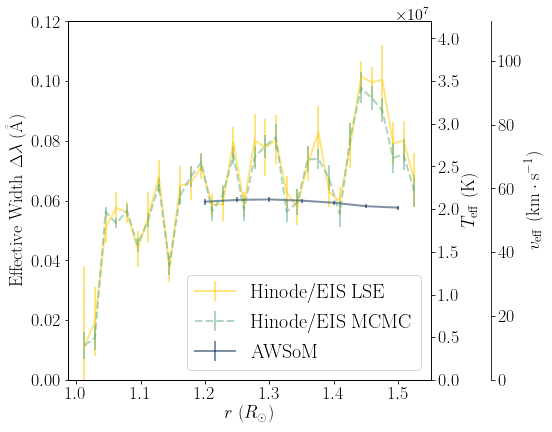

In [424]:
fig, ax = plt.subplots(figsize=(8,6))
ln1 = ax.errorbar(r_coord,fwhm_193_cor,yerr = fwhm_193_err,color = '#FFCB05',linewidth=2,alpha=0.5,label="Hinode/EIS LSE")
ln2 = ax.errorbar(height,fit_para[:,2]*2.355,yerr = fit_para_err[:,2]*2.355,color="#00274C",lw=2,alpha=0.5,label="AWSoM")
ln3 = ax.errorbar(r_coord,fwhm_193_cor_mcmc,yerr = [fwhm_193_err_down_mcmc,fwhm_193_err_up_mcmc],color = '#5DAC81',
                  linewidth=2,ls = '--',alpha=0.5,label='Hinode/EIS MCMC')
ax.set_ylim((0,0.12))
ax_t = ax.twinx()
ax_v = ax.twinx()
ax_v.spines['right'].set_position(('outward', 60))
ax_t_ticks = np.square(np.array([0.,0.12])/193.509*c)*56*amu/2/k_B/(4*np.log(2))
ax_v_ticks = np.array([0.,0.12])/192.394*c/np.sqrt(4*np.log(2))/1.e5


ax_t.set_ylim((ax_t_ticks[0],ax_t_ticks[-1]))
ax_t.yaxis.get_offset_text().set_fontsize(16)
ax_t.set_ylabel(r'$T_{\rm eff}$ (K)',fontsize = 18)

ax_v.set_ylim((ax_v_ticks[0],ax_v_ticks[-1]))
ax_v.set_ylabel(r'$v_{\rm eff}\ (\mathrm{km\cdot s^{-1}})$',fontsize = 18)

for ax_ in (ax_t,ax_v):
    ax_.tick_params(labelsize=18)
    
ax.set_xlabel(r'$r\ (R_\odot)$',fontsize=18)
ax.set_ylabel(r'Effective Width $\Delta \lambda\ (\mathrm{\AA})$',fontsize=18)
ax.tick_params(labelsize=18)
leg = [ln1,ln3,ln2]
ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'lower right',fontsize = 20)
plt.subplots_adjust(bottom = 0.12,left=0.15,top=0.95,right=0.78)
plt.savefig(fname = r'/Users/yjzhu/Desktop/Courses/2020WIN/SPACE477/project3/figs/vnt.pdf', dpi = 300, format = 'pdf')

In [367]:
fit_para[6,]

array([2.60000388e-01, 1.93509000e+02, 3.47377014e-02, 2.77636850e-03])

In [211]:
aa = np.array([[1,2,3],[1,2,3]])
bb = np.array([1,2])
aa*bb[:,np.newaxis]

array([[1, 2, 3],
       [2, 4, 6]])